In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# Any results you write to the current directory are saved as output.

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [110]:
!pip install wordcloud

# Business & Data Understanding
- What's ratio of super hosts relative to normal hosts?
- How do super hosts describe their listings that is different from normal hosts?
- What do tenents value about super hosts relative to normal hosts?

In [146]:
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS

In [6]:
os.chdir(r'F:\pf')

In [237]:
listing_df = pd.read_csv(r'kaggle/input/seattle/listings.csv')
review_df = pd.read_csv(r'kaggle/input//seattle/reviews.csv')
calendar_df = pd.read_csv(r'kaggle/input//seattle/calendar.csv')

- 19.5% of all hosts are super hosts. 
- This ratio is not too imbalanced and their difference relative to normal hosts is worth digging into

In [242]:
listing_df[['host_id','host_is_superhost']].drop_duplicates().host_is_superhost.value_counts()

f    2212
t     537
Name: host_is_superhost, dtype: int64

In [243]:
537/(2212+537)

0.1953437613677701

# Data Preparation
Start by looking at missing values and categorical data, aim is to clean and select useful columns

In [244]:
review_df.isnull().mean()

listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.000212
dtype: float64

In [14]:
review_df[review_df.comments.isnull()]

,listing_id,id,date,reviewer_id,reviewer_name,comments
11034,461567,11614247,2014-04-09,12120141,Abbey,NaN
15383,9460,10563024,2014-02-24,12498029,Debra,NaN
15914,2906694,48629316,2015-09-27,44218980,Anush,NaN
16097,910784,9950520,2014-01-21,179481,Enrico,NaN
27280,10695,52378,2010-06-13,105412,Wei,NaN
29467,1018204,10024984,2014-01-26,10571694,Jordan,NaN
30619,6079216,34824019,2015-06-12,31556342,Mack,NaN
31414,3354614,18103248,2014-08-21,12426758,Jeff,NaN
35210,3554558,24863045,2015-01-03,24488791,Eleanor,NaN
37971,1790020,15640556,2014-07-13,16884291,Michael,NaN


- Review_df contains few missing value. The reason for missing is most likely customers didn't bother making one. So, for purpose of NLP, we may just drop these observations.

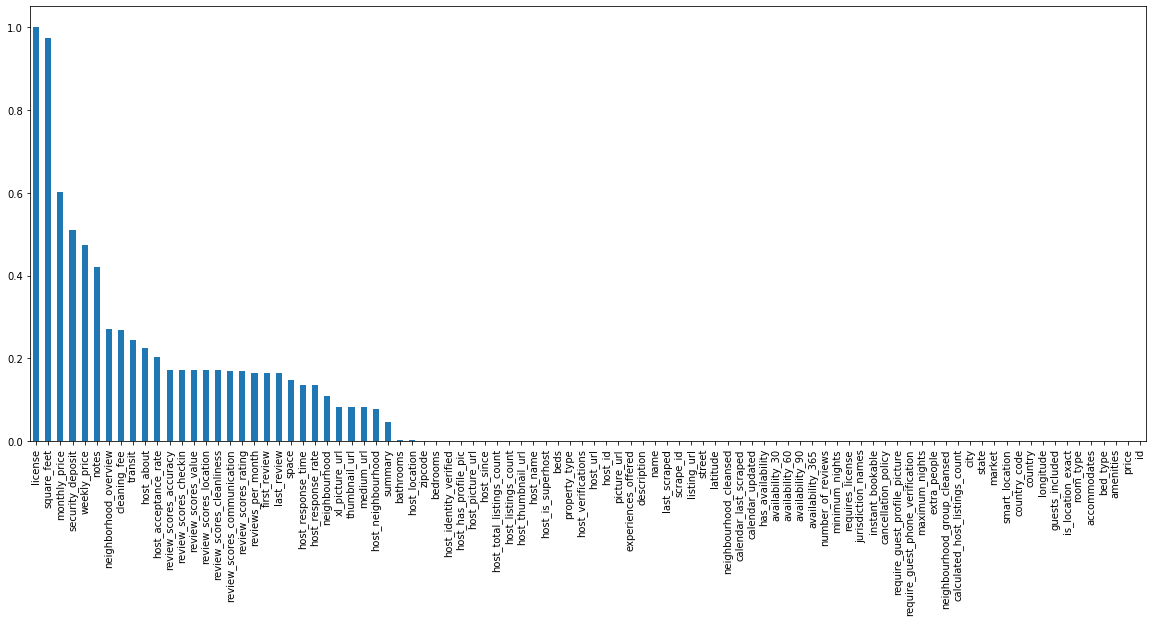

In [254]:
listing_df.isnull().mean().sort_values(ascending = False).plot.bar(figsize = (20,8))

- Most columns have few missing values
- license and square feet are not relevant to our analysis and is not so important

In [17]:
listing_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

- Some columns are redundant since they essentially contain only one value

In [103]:
listing_df.market.unique()

array(['Seattle'], dtype=object)

## Analyzing Hosts: data cleaning

- Get host specific columns
- Investigate missing values of these columns

In [18]:
host_cols = [x for x in listing_df.columns if re.search('host',x)]

In [19]:
# Pick columns to control for host 
listing_df[host_cols].isnull().mean().sort_values()

host_id                           0.000000
host_verifications                0.000000
calculated_host_listings_count    0.000000
host_url                          0.000000
host_since                        0.000524
host_identity_verified            0.000524
host_thumbnail_url                0.000524
host_picture_url                  0.000524
host_listings_count               0.000524
host_total_listings_count         0.000524
host_has_profile_pic              0.000524
host_name                         0.000524
host_is_superhost                 0.000524
host_location                     0.002095
host_neighbourhood                0.078575
host_response_time                0.136983
host_response_rate                0.136983
host_acceptance_rate              0.202462
host_about                        0.224987
dtype: float64

By looking at the record with host_picture null, we can find that these hosts simply have no information recorded, either because of data entry problem. When analyzing hosts, I will just discard these missing values since they are small in number and contains little information.

In [20]:
listing_df[listing_df.host_picture_url.isnull()][host_cols]

,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count
1297,42515980,https://www.airbnb.com/users/show/42515980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,1
1419,1075031,https://www.airbnb.com/users/show/1075031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,1


In [21]:
host_df = listing_df[['host_id','host_since','host_identity_verified','host_listings_count','host_is_superhost','host_has_profile_pic','host_total_listings_count']]

In [22]:
host_df.dropna(inplace = True)

F:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Create a single variable to measure level of verification using identity verified and has pic

In [23]:
host_df = host_df.set_index('host_id')

In [24]:
host_df.host_identity_verified = (host_df.host_identity_verified == 't').astype(int)
host_df.host_has_profile_pic = (host_df.host_has_profile_pic == 't').astype(int)
#host_df['verify_level'] = host_df.host_identity_verified + host_df.host_has_profile_pic

In [25]:
import seaborn as sns

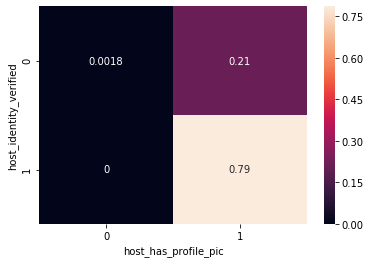

In [26]:
sns.heatmap(host_df.groupby(['host_identity_verified','host_has_profile_pic']).agg({'host_since':'count'}).unstack().droplevel(axis = 1,level = 0).fillna(0)/host_df.shape[0],annot = True)

- Most hosts have a picture in their profile, so, our analysis will focus on whether they have verified themselves may be important

In [27]:
(host_df.host_listings_count == host_df.host_total_listings_count).mean()

1.0

- Another duplicate column

In [28]:
host_df.drop('host_total_listings_count',axis = 1,inplace = True)

## Analyzing host listing and Experience

### Host number  decay exponentially with listing number for most, but outliers exist

In [260]:
host_df.host_since = host_df.host_since.astype(np.datetime64)

In [30]:
host_df.host_since.describe()

count                    3816
unique                   1380
top       2013-08-30 00:00:00
freq                       51
first     2008-11-10 00:00:00
last      2016-01-03 00:00:00
Name: host_since, dtype: object

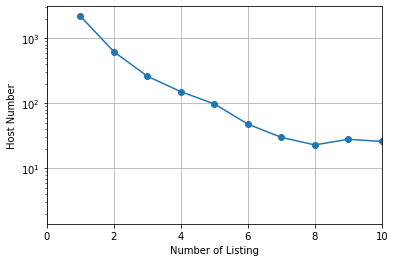

In [95]:
host_df.host_listings_count.value_counts().sort_index().plot(marker = 'o',logy = True)
plt.xlim([0,10])
plt.ylabel('Host Number')
plt.xlabel('Number of Listing')
plt.grid()

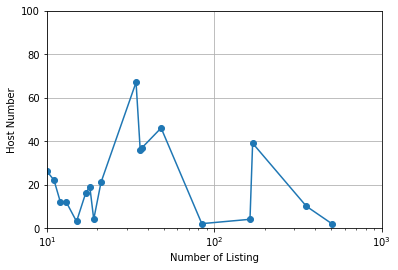

In [94]:
host_df.host_listings_count.value_counts().sort_index().plot(marker = 'o',logx = True)
plt.xlim([10,1000])
plt.ylim([0,100])
plt.ylabel('Host Number')
plt.xlabel('Number of Listing')
plt.grid()

In [32]:
host_df['experience'] = host_df.host_since.max() - host_df.host_since

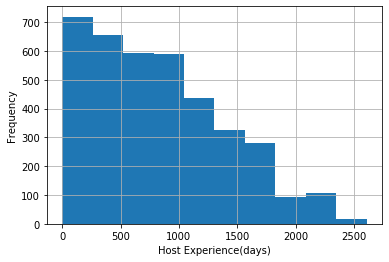

In [48]:
host_df['experience'].dt.days.plot.hist()
plt.xlabel('Host Experience(days)')
plt.grid()

In [49]:
host_df['start_year'] = host_df.host_since.dt.year

In [64]:
host_df['start_quarter'] = host_df.host_since.dt.quarter

In [54]:
host_df.host_is_superhost = host_df.host_is_superhost == 't'

In [74]:
host_growth = host_df.groupby(['start_year','start_quarter']).host_is_superhost.count().rename('host_count')
host_quality = host_df.groupby(['start_year','start_quarter']).host_is_superhost.mean().rename('host_super')
host_ts = pd.merge(host_growth,host_quality,left_index = True, right_index = True)

### It seems that it takes two years to distinguish super hosts from normal ones
- Therefore, I will use hosts with at least two years of experience for comparison
- Host counts seems to grow steadily, with seasonality. The peak is usually the third quarter

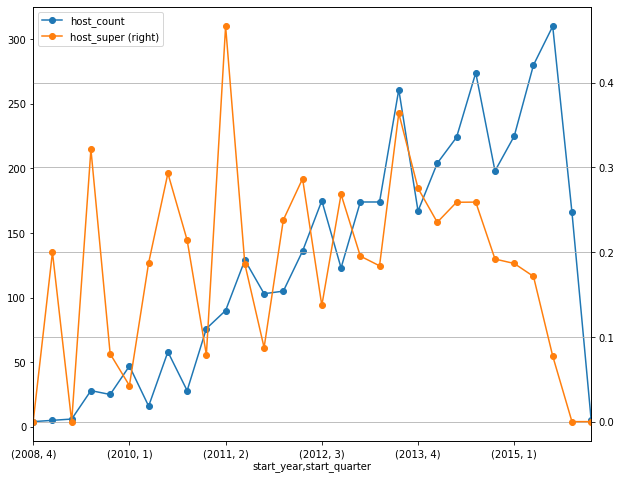

In [76]:
host_ts.plot(figsize = (10,8),secondary_y = 'host_super',marker = 'o')
plt.grid()

## What do a superhost do differently than normal ones?
- Super hosts are more likely to verify themselves
- Normal hosts seem to list more, but based on our analysis above, it's very likely that outliers play an important role
- Excluding hosts with more 100 listings (maybe a company), super hosts list on average two more listings
- Excluding listings more than 20 or 10, the two kinds of hosts list very similar number of listings: hard to conclude that super hosts are just professional hosts.

In [101]:
host_df[host_df.host_since <'2014'].groupby('host_is_superhost').mean()[['host_identity_verified','host_listings_count']]

,host_identity_verified,host_listings_count
host_is_superhost,,
False,0.835246,10.672519
True,0.937639,7.173719


In [263]:
host_df[(host_df.host_since <'2014') & (host_df.host_listings_count <= 100)].groupby('host_is_superhost').mean()[['host_identity_verified','host_listings_count']]

,host_identity_verified,host_listings_count
host_is_superhost,,
False,0.830320,5.954798
True,0.937639,7.173719


In [264]:
host_df[(host_df.host_since <'2014') & (host_df.host_listings_count <= 20)].groupby('host_is_superhost').mean()[['host_identity_verified','host_listings_count']]

,host_identity_verified,host_listings_count
host_is_superhost,,
False,0.811728,2.663580
True,0.930521,2.513648


In [262]:
host_df[(host_df.host_since <'2014') & (host_df.host_listings_count <= 10)].groupby('host_is_superhost').mean()[['host_identity_verified','host_listings_count']]

,host_identity_verified,host_listings_count
host_is_superhost,,
False,0.826613,2.160484
True,0.928389,2.191816


## What do super hosts do differently when describing their listings?

In [111]:
from wordcloud import WordCloud, STOPWORDS

In [127]:
listing_df.drop(listing_df.columns[listing_df.nunique() == 1].tolist(),axis = 1,inplace = True)

In [166]:
review_for_merge = review_df[['listing_id','comments']]

In [156]:
super_host_df = host_df[host_df.host_is_superhost == True]
super_host_df = super_host_df[super_host_df.host_since <'2014'] # Make sure the comparablility

normal_host_df = host_df[host_df.host_is_superhost == False]
normal_host_df = normal_host_df[normal_host_df.host_since < '2014'] # Make sure the comparablility

review_for_merge = review_for_merge.groupby('listing_id').sum()

In [257]:
host_text_analysis = pd.merge(listing_df[['host_id','id','summary','name','description','transit','space','notes','host_about']],review_for_merge,left_on ='id', right_index = True,how = 'left')

In [258]:
super_host_id = super_host_df.index.tolist()
normal_host_id = normal_host_df.index.tolist()
host_text_analysis = host_text_analysis.drop('id',axis = 1)

In [229]:
def woodCloud_compare_superhost(col,super_host_df = super_host_df,normal_host_df = normal_host_df,addtional_stopwords = ['Seattle','house','will']):
    '''Use word cloud to campre the two kinds of host'''
    my_stopwords = STOPWORDS | set(addtional_stopwords)
    word_cloud_superhost = WordCloud(stopwords =my_stopwords,background_color = 'white')\
    .generate(" ".join(host_text_analysis[host_text_analysis.host_id.isin(super_host_id)][col].dropna()))
    plt.figure(figsize = (10,8))
    plt.title(col+' for Superhosts',fontsize = 20)
    plt.imshow(word_cloud_superhost)
    
    word_cloud_host = WordCloud(stopwords =my_stopwords,background_color = 'white')\
    .generate(" ".join(host_text_analysis[host_text_analysis.host_id.isin(normal_host_id)][col].dropna()))
    plt.figure(figsize = (10,8))
    plt.title(col+' for normalhosts',fontsize = 20)
    plt.imshow(word_cloud_host)

### Lesson from naming: super hosts focus on privacy rather than view. 
- Clearly, privacy is more realistic issue compared to view!

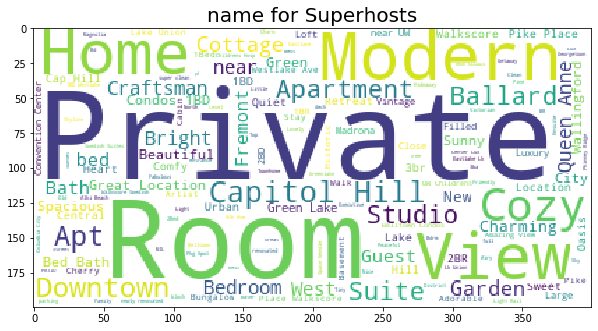

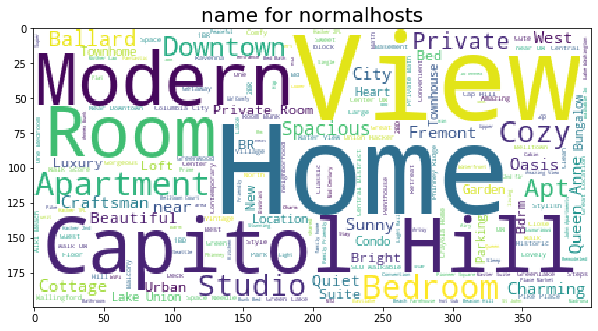

In [232]:
woodCloud_compare_superhost('name')

### Summary for the listing: not so different, private still plays a role

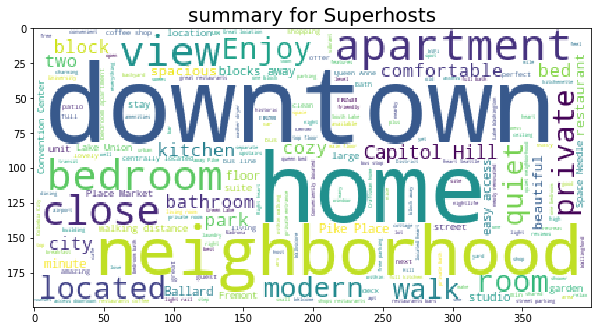

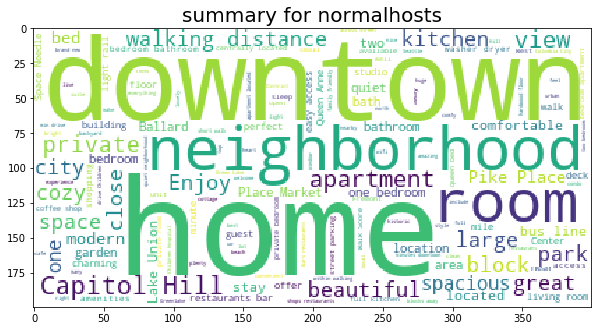

In [231]:
woodCloud_compare_superhost('summary')

### Description: mention guest much more frequently

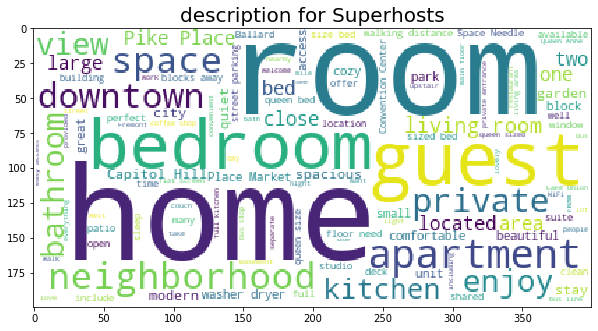

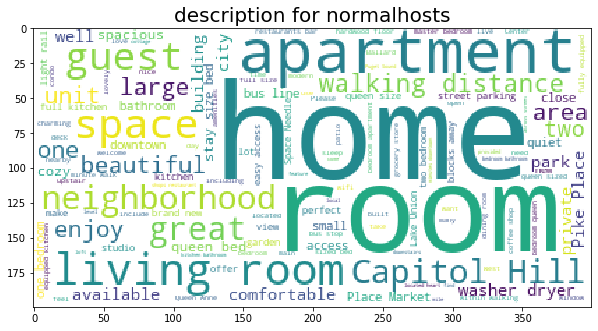

In [233]:
woodCloud_compare_superhost('description')

### Transit: mention 'airport' more frequently. They can think better from customers' perspective.

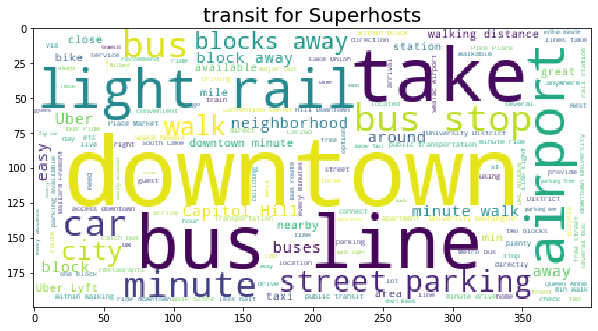

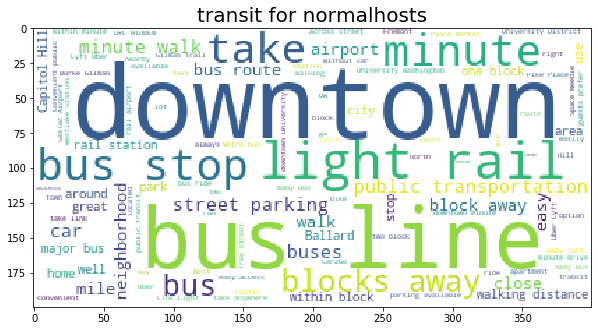

In [234]:
woodCloud_compare_superhost('transit')

### Notes: Super hosts are more polite ('Please') and focus more on customer needs ('need')

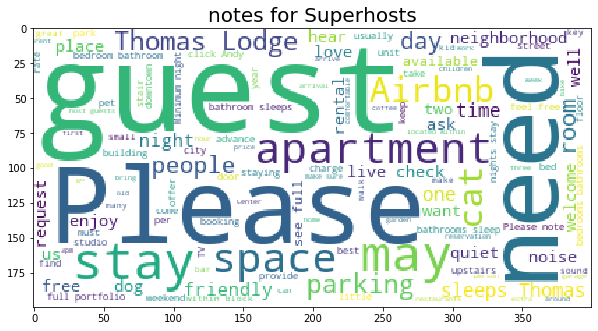

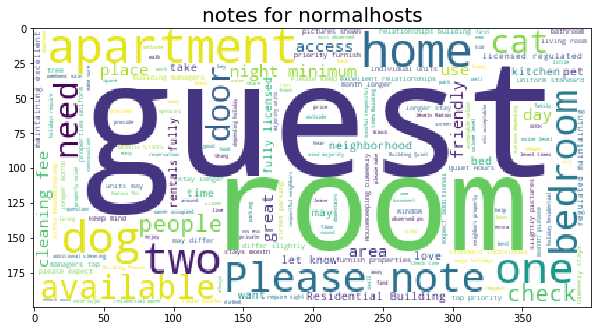

In [236]:
woodCloud_compare_superhost('notes')

### What do super hosts do differently in decribing their listing?
- They are more customer - oriented.
- They keep practical issues of customers in mind.

## Customers Perspective: What do Customers value in super hosts?
- Feeling like home
- Location is more important for normal hosts
- Benefit of superhost: more customers will recommend you!

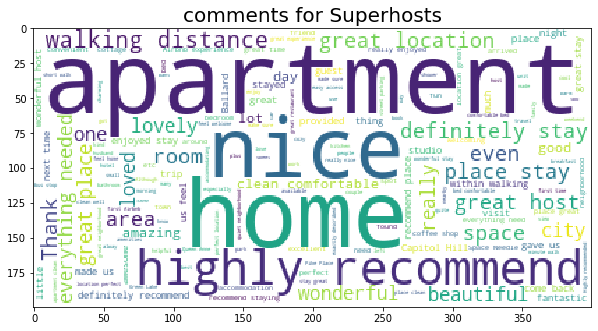

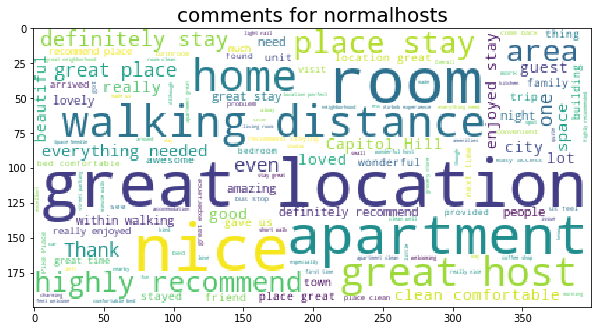

In [230]:
woodCloud_compare_superhost('comments')